# Pre-processing

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)

## Explore our dataset

What is MMSE ? https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/GetPdf.cgi?id=phd001525.1

In [145]:
df1 = pd.read_csv("dataset\ADNI_patient_data_tab.txt", delimiter = "\t")
# remove useless columns
df1 = df1[['RID', 'VISCODE','MMSE']]
print(df1.shape)
print(df1.head())
print(df1.describe())

(7359, 3)
   RID VISCODE  MMSE
0    2      bl  28.0
1    2     m06  28.0
2    2     m36  29.0
3    4      bl  27.0
4    4     m06  28.0
               RID         MMSE
count  7359.000000  6546.000000
mean   2689.779997    27.603880
std    2014.320955     2.755753
min       2.000000     3.000000
25%     746.000000    26.000000
50%    2205.000000    28.000000
75%    4513.000000    30.000000
max    6653.000000    30.000000


In [146]:
# drop records with no MMSE score
df1.dropna(inplace=True)

# change VISCODE column into a numerical feature
# bl = 0, m06 = 1, m12 = 2,...
df1['VISCODE'].replace({"bl": 0, "m06": 1,"m12": 2, "m18": 3,"m24": 4, "m36": 6}, inplace=True)

print(df1.shape)
print(df1.head())

(6546, 3)
   RID  VISCODE  MMSE
0    2        0  28.0
1    2        1  28.0
2    2        6  29.0
3    4        0  27.0
4    4        1  28.0


In [147]:
df2 = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")

#replace categorical feature with index labeling
df2['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df2['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df2.loc[:,'RID':'VISCODE']
data = df2.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']

print(data.shape)
print(data.head())

(135, 320)
   A1AT.AVLTIDEK  A1AT.LSITGTYDLK  A1AT.SVLGQLGITK  A1BG.NGVAQEPVHLDSPAIK  \
1      10.949712         7.708165         9.573963              14.975933   
2      10.764089         8.144418         9.561409              15.415546   
4      10.650946         8.176241         9.504176              14.697074   
5      10.197844         7.629740         9.583185              16.132868   
6      11.695952         7.426978        10.114171              15.591507   

   A1BG.SGLSTGWTQLSK  A2GL.DLLLPQPDLR  A2GL.VAAGAFQGLR  A4.LVFFAEDVGSNK  \
1          19.567221        25.348033        22.576139        17.931089   
2          20.143607        25.650222        22.693205        17.896346   
4          19.297921        24.972259        22.127365        17.502211   
5          20.854108        26.251222        23.343968        17.695674   
6          20.422715        25.570846        22.853105        18.097084   

   A4.THPHFVIPYR  A4.WYFDVTEGK  AACT.ADLSGITGAR  AACT.EIGELYLPK  \
1      2

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

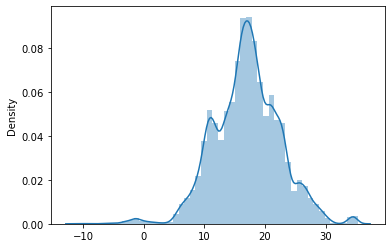

In [148]:
#check dataset distribution
sns.distplot(data)

Why negative values ? Because data has already been log-normalized -> low intensities of a protein are negative.

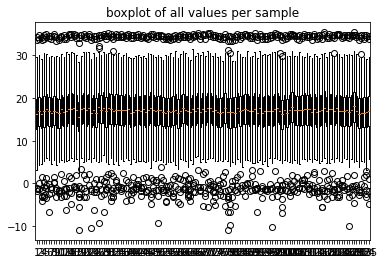

In [149]:
#plot each sample boxplot
plt.boxplot(data.transpose())
plt.title('boxplot of all values per sample')
plt.show()

Distribution of dataset does not seem to be nicely normally distributed -> need to be normalized

## Normalization

In [150]:
#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])

### Quantile Normalization

From other paper:\
The quantile technique was the most unique in that an iterative process was not required for normalization. Additionally, this normalization technique does not force the means of replicate samples to converge upon a predetermined value, as was observed in the case of the other three normalization techniques (i.e., central tendency, linear regression, and local regression), where the mean of relative peptide abundances were forced to converge to zero. When the quantile technique was applied to our data, the mean of the common distribution following normalization fell within the range of means for the compared runs. This observation has an important implication related to the selection of a normalization technique and to the number of peptides common to all replicates runs used in the normalization process. Since we opted to perform central tendency, linear regression, and local regression normalization on a global scale, where measured abundances of all common peptides are used, we assumed that the leverage of peptide ratios containing biological variability on the mean relative abundance of the set of peptide ratios would not be significant. Such an assumption is commonly made for mRNA expression analysis where arrays are designed to target a large or complete set of open reading frames 21. In the case of high-throughput proteomics large number of peptides can be detected, but peptides can fail to be detected for many reasons (changes in the LC separation, the overshadowing of less abundant peptides by highly abundant peptides in the same spectrum, variations in MS performance, etc.) 3, 10. Hence, the mean relative abundance of replicate sets of peptide ratios may indeed lie above or below zero. In such a case, quantile normalization would be more suitable for reducing variability among these replicate runs.

In [151]:
#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(data)
data = df_qn
norm_test(data)

There are  320 normally distributed features out of 320


### Box-cox transformation

Data must be positive !

The objective is to obtain a normal distribution of the transformed data (after transformation) and a constant variance.

If a logarithmic transformation is applied to this distribution, the differences between smaller values will be expanded (because the slope of the logarithmic function is steeper when values are small) whereas the differences between larger values will be reduced (because of the very moderate slope of the log distribution for larger values). If you inflate differences on the left tail and reduce differences on the right side tail, the result will be a symmetrical normal distribution, and a variance that is now constant (whatever the mean).

In [152]:
#compute box-cox transformation
df_bc = pd.DataFrame().reindex_like(data)

for col in df_qn:
    df_bc[col],_ = stats.boxcox(df_qn[col])
data = df_qn
norm_test(data)

There are  320 normally distributed features out of 320


C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

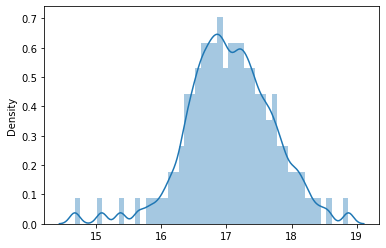

In [153]:
#check if data is better normally distributed
sns.distplot(data)

### Merge two dataset on RID

In [154]:
data['RID'] = pheno['RID']

df = pd.merge(df1, data, on="RID")
#df.drop(['RID'],axis=1,inplace=True)
print(df.shape)
print(df.head())

(751, 323)
   RID  VISCODE  MMSE  A1AT.AVLTIDEK  A1AT.LSITGTYDLK  A1AT.SVLGQLGITK  \
0    4        0  27.0      17.589236        16.940455        16.725098   
1    4        1  28.0      17.589236        16.940455        16.725098   
2    4        2  26.0      17.589236        16.940455        16.725098   
3    4        3  27.0      17.589236        16.940455        16.725098   
4    4        6  25.0      17.589236        16.940455        16.725098   

   A1BG.NGVAQEPVHLDSPAIK  A1BG.SGLSTGWTQLSK  A2GL.DLLLPQPDLR  A2GL.VAAGAFQGLR  \
0              16.545809          16.397941        16.530796        16.624354   
1              16.545809          16.397941        16.530796        16.624354   
2              16.545809          16.397941        16.530796        16.624354   
3              16.545809          16.397941        16.530796        16.624354   
4              16.545809          16.397941        16.530796        16.624354   

   A4.LVFFAEDVGSNK  A4.THPHFVIPYR  A4.WYFDVTEGK  AACT.ADL

### split in train, validation and test set (80,10,10%)

In [155]:
print(df.shape)
train1 = df.loc[1:df.shape[0]*0.8]
val1 = df.loc[df.shape[0]*0.8:df.shape[0]*0.9]
test1 = df.loc[df.shape[0]*0.9:df.shape[0]]

print(train1.shape,val1.shape,test1.shape)

df.to_csv(r'dataset\full.csv')
train1.to_csv(r'dataset\train1.csv')
val1.to_csv(r'dataset\validation.csv')
test1.to_csv(r'dataset\test1.csv')

(751, 323)
(600, 323) (75, 323) (75, 323)


## Refine proteins columns to avoid redundance info using PCA components

In [156]:
# from sklearn.decomposition import PCA

# # Make an instance of the Model keeping 95% of the features variance is retained
# pca = PCA(0.95)

# PCA_train = df.drop(columns=['RID','MMSE'])
# PCA_test = df['MMSE']

# principalComponents = pca.fit_transform(PCA_train)
# principalDf = pd.DataFrame(data = principalComponents)
# print('Note that we now have',principalDf.shape[1],'columns instead of',X.shape[1])
# df = df[['RID','VISCODE','MMSE']]

# df = pd.concat([df.reset_index(drop=True), principalDf.reset_index(drop=True)], axis=1)
df.head(10)

,RID,VISCODE,MMSE,A1AT.AVLTIDEK,A1AT.LSITGTYDLK,A1AT.SVLGQLGITK,A1BG.NGVAQEPVHLDSPAIK,A1BG.SGLSTGWTQLSK,A2GL.DLLLPQPDLR,A2GL.VAAGAFQGLR,A4.LVFFAEDVGSNK,A4.THPHFVIPYR,A4.WYFDVTEGK,AACT.ADLSGITGAR,AACT.EIGELYLPK,AACT.NLAVSQVVHK,AATC.IVASTLSNPELFEEWTGNVK,AATC.LALGDDSPALK,AATC.NLDYVATSIHEAVTK,AATM.FVTVQTISGTGALR,AFAM.DADPDTFFAK,AFAM.FLVNLVK,AFAM.LPNNVLQEK,ALDOA.ALQASALK,ALDOA.QLLLTADDR,AMBP.AFIQLWAFDAVK,AMBP.ETLLQDFR,AMBP.FLYHK,AMD.IPVDEEAFVIDFKPR,AMD.IVQFSPSGK,AMD.NGQWTLIGR,APLP2.HYQHVLAVDPEK,APLP2.WYFDLSK,APOB.IAELSATAQEIIK,APOB.SVSLPSLDPASAK,APOB.TGISPLALIK,APOD.VLNQELR,APOE.AATVGSLAGQPLQER,APOE.CLAVYQAGAR,APOE.LAVYQAGAR,APOE.LGADMEDVR,APOE.LGPLVEQGR,B2MG.VEHSDLSFSK,B2MG.VNHVTLSQPK,B3GN1.EPGEFALLR,B3GN1.TALASGGVLDASGDYR,B3GN1.YEAAVPDPR,BACE1.SIVDSGTTNLR,BASP1.ETPAATEAPSSTPK,BTD.LSSGLVTAALYGR,BTD.SHLIIAQVAK,C1QB.LEQGENVFLQATDK,C1QB.VPGLYYFTYHASSR,CA2D1.FVVTDGGITR,CA2D1.IKPVFIEDANFGR,CA2D1.TASGVNQLVDIYEK,CAD13.DIQGSLQDIFK,CAD13.INENTGSVSVTR,CAD13.YEVSSPYFK,CADM3.EGSVPPLK,CADM3.GNPVPQQYLWEK,CADM3.SLVTVLGIPQKPIITGYK,CAH1.VLDALQAIK,CAH1.YSSLAEAASK,CATA.LFAYPDTHR,CATD.LVDQNIFSFYLSR,CATD.VSTLPAITLK,CATD.YSQAVPAVTEGPIPEVLK,CATL1.VFQEPLFYEAPR,CCKN.AHLGALLAR,CCKN.NLQNLDPSHR,CD14.AFPALTSLDLSDNPGLGER,CD14.FPAIQNLALR,CD14.SWLAELQQWLKPGLK,CD59.AGLQVYNK,CERU.IYHSHIDAPK,CERU.NNEGTYYSPNYNPQSR,CFAB.DAQYAPGYDK,CFAB.VSEADSSNADWVTK,CFAB.YGLVTYATYPK,CH3L1.ILGQQVPYATK,CH3L1.SFTLASSETGVGAPISGPGIPGR,CH3L1.VTIDSSYDIAK,CLUS.IDSLLENDR,CLUS.SGSGLVGR,CLUS.VTTVASHTSDSDVPSGVTEVVVK,CMGA.EDSLEAGLPLQVR,CMGA.SEALAVDGAGKPGAEEAQDPEGK,CMGA.SGEATDGARPQALPEPMQESK,CMGA.SGELEQEEER,CMGA.YPGPQAEGDSEGLSQGLVDR,CNDP1.ALEQDLPVNIK,CNDP1.VFQYIDLHQDEFVQTLK,CNDP1.WNYIEGTK,CNTN1.DGEYVVEVR,CNTN1.TTKPYPADIVVQFK,CNTN2.IIVQAQPEWLK,CNTN2.TTGPGGDGIPAEVHIVR,CNTN2.VIASNILGTGEPSGPSSK,CNTP2.HELQHPIIAR,CNTP2.VDNAPDQQNSHPDLAQEEIR,CNTP2.YSSSDWVTQYR,CO2.DFHINLFR,CO2.HAIILLTDGK,CO2.SSGQWQTPGATR,CO3.IHWESASLLR,CO3.LSINTHPSQKPLSITVR,CO3.TELRPGETLNVNFLLR,CO3.TGLQEVEVK,CO3.VPVAVQGEDTVQSLTQGDGVAK,CO4A.DHAVDLIQK,CO4A.GSFEFPVGDAVSK,CO4A.LGQYASPTAK,CO4A.NVNFQK,CO4A.VLSLAQEQVGGSPEK,CO4A.VTASDPLDTLGSEGALSPGGVASLLR,CO5.DINYVNPVIK,CO5.TLLPVSKPEIR,CO5.VFQFLEK,CO6.ALNHLPLEYNSALYSR,CO6.SEYGAALAWEK,CO8B.IPGIFELGISSQSDR,CO8B.SDLEVAHYK,CO8B.YEFILK,COCH.GVISNSGGPVR,CRP.ESDTSYVSLK,CSTN1.GNLAGLTLR,CSTN1.IHGQNVPFDAVVVDK,CSTN1.IPDGVVSVSPK,CSTN3.ATGEGLIR,CSTN3.ESLLLDTTSLQQR,CUTA.TQSSLVPALTDFVR,CYTC.ALDFAVGEYNK,DAG1.GVHYISVSATR,DAG1.LVPVVNNR,DAG1.VTIPTDLIASSGDIIK,DIAC.ATYIQNYR,ENOG.GNPTVEVDLYTAK,ENOG.LGAEVYHTLK,ENPP2.SYPEILTLK,ENPP2.WWGGQPLWITATK,EXTL2.VIVVWNNIGEK,FABPH.SIVTLDGGK,FABPH.SLGVGFATR,FAM3C.GINVALANGK,FAM3C.SALDTAAR,FAM3C.SPFEQHIK,FAM3C.TGEVLDTK,FBLN1.AITPPHPASQANIIFDITEGNLR,FBLN1.IIEVEEEQEDPYLNDR,FBLN1.TGYYFDGISR,FBLN3.IPSNPSHR,FBLN3.LTIIVGPFSF,FBLN3.SGNENGEFYLR,FETUA.AHYDLR,FETUA.FSVVYAK,FETUA.HTLNQIDEVK,FMOD.YLPFVPSR,GFAP.ALAAELNQLR,GOLM1.DQLVIPDGQEEEQEAAGEGR,GOLM1.QQLQALSEPQPR,GRIA4.EYPGSETPPK,GRIA4.LQNILEQIVSVGK,GRIA4.NTDQEYTAFR,HBA.FLASVSTVLTSK,HBA.TYFPHFDLSHGSAQVK,HBA.VGAHAGEYGAEALER,HBB.EFTPPVQAAYQK,HBB.SAVTALWGK,HBB.VNVDEVGGEALGR,HEMO.NFPSPVDAAFR,HEMO.QGHNSVFLIK,HEMO.SGAQATWTELPWPHEK,I18BP.LWEGSTSR,IBP2.HGLYNLK,IBP2.LIQGAPTIR,IGSF8.DTQFSYAVFK,IGSF8.LQGDAVVLK,IGSF8.VVAGEVQVQR,ITIH1.EVAFDLEIPK,ITIH1.QYYEGSEIVVAGR,ITIH5.SYLEITPSR,KAIN.FYYLIASETPGK,KAIN.LGFTDLFSK,KAIN.VGSALFLSHNLK,KAIN.WADLSGITK,KLK10.ALQLPYR,KLK11.LPHTLR,KLK6.ESSQEQSSVVR,KLK6.LSELIQPLPLER,KLK6.YTNWIQK,KNG1.DIPTNSPELEETLTHTITK,KNG1.QVVAGLNFR,KNG1.TVGSDTFYSFK,KPYM.LDIDSPPITAR,L1CAM.AQLLVVGSPGPVPR,L1CAM.LVLSDLHLLTQSQVR,L1CAM.WRPVDLAQVK,LAMB2.AQGIAQGAIR,LPHN1.LVVSQLNPYTLR,LPHN1.SGETVINTANYHDTSPYR,LRC4B.HLEILQLSK,LRC4B.LTTVPTQAFEYLSK,LTBP2.EQDAPVAGLQPVER,MIME.ESAYLYAR,MIME.ETVIIPNEK,MIME.LEGNPIVLGK,MOG.VVHLYR,MUC18.EVTVPVFYPTEK,MUC18.GATLALTQVTPQDER,NBL1.LALFPDK,NCAM1.AGEQDATIHLK,NCAM1.GLGEISAASEFK,NCAM2.ASGSPEPAISWFR,NCAM2.IIELSQTTAK,NCAN.APVLELEK,NCAN.LSSAIIAAPR,NEGR1.SSIIFAGGDK,NEGR1.VVVNFAPTIQEIK,NEGR1.WSVDPR,NELL2.AFLFQDTPR,NELL2.FTGSSWIK,NELL2.SALAYVDGK,NEO1.DVVASLVSTR,NEUS.ALGITEIFIK,NEUS.QEVPLATLEPLVK,NGF.SAPAAAIAAR,NICA.ALADVATVLGR,

### Granger Causality Test
To investigate causality of data\
The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y, so the x does not cause y

In [157]:
# from statsmodels.tsa.stattools import grangercausalitytests

# count=0
# for rid in df['RID'].unique():
#     rej_count = 0
#     for col in df.loc[df['RID']==rid].columns:
#         test_result = grangercausalitytests(df[[col,'MMSE']], maxlag=20, verbose=False)
#         p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(20)]            
#         min_p_value = np.min(p_values)
#         if min_p_value<=0.05:
#             rej_count+=1
#     count+=1
#     if count>=5:
#         break
            
#     print('Record',rid,'has',rej_count,'columns out of',df.shape[1]-1,'that reject the null hypothesis (so that can cause MMSE)')
    

We can see that it's always the same columns that can cause MMSE, and there are only 14, so this dataset is not very good in causing MMSE

### Stationary test (Augmented Dickey-Fuller Test (ADF Test)
To check stationary of each variable in the dataset. If the stationarity is not achieved, we need to make the data stationary, such as eliminating the trend and seasonality by differencing and seasonal decomposition.\
The Null Hypothesis is that the data has unit root and is not stationary

In [158]:
# from statsmodels.tsa.stattools import adfuller

# count=0
# for rid in df['RID'].unique():
#     rej_count = 0
#     for col in df.loc[df['RID']==rid].columns:
#         res = adfuller(df[col], autolag='AIC')    
#         p_value = round(res[1], 3) 
#         if p_value <= 0.05:
#             rej_count+=1
#     count+=1
#     if count>=5:
#         break
    
#     print('Record',rid,'has',rej_count,'columns out of',df.shape[1]-1,'that reject the null hypothesis (so that are stationary)')

So, there is no need to use differecing method

## Split dataset
To split the data, I will always keep 2/3 of the days per record in the training set and 1/3 in the test set\
2  -> 1 and 1\
   3          -> 2 and 1\
   4          -> 3 and 1\
   5          -> 3 and 2\
   6          -> 4 and 2

In [159]:
train = df.iloc[:0,:].copy()
test = df.iloc[:0,:].copy()

for i in df['RID'].unique():
    count = len(df.loc[df['RID']==i])
    for j in range(round(2*count/3)):
        record = df.loc[df.index[df['RID']==i][0]].transpose()
        train = train.append(record,ignore_index=True,sort=False)
        df.drop(df.index[df['RID']==i][0],axis=0,inplace=True)
    for j in range(round(count/3)):
        record = df.loc[df.index[df['RID']==i][0]].transpose()
        test = test.append(record,ignore_index=True,sort=False)
        df.drop(df.index[df['RID']==i][0],axis=0,inplace=True)


## Export dataset

In [160]:
#export to csv file

train.to_csv(r'dataset\train.csv')
test.to_csv(r'dataset\test.csv')
# X_train.to_csv(r'dataset\X_train.csv')
# X_test.to_csv(r'dataset\X_test.csv')
# y_train.to_csv(r'dataset\y_train.csv')
# y_test.to_csv(r'dataset\y_test.csv')

## Test on plotting timeseries

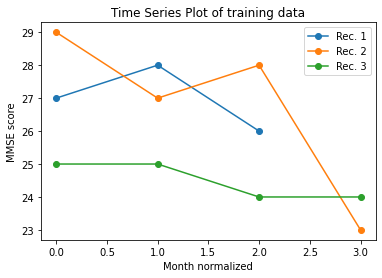

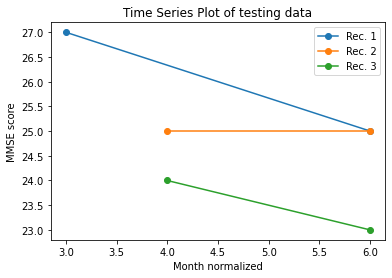

In [161]:
# Plot
labels = ['Rec. 1','Rec. 2','Rec. 3']
counter=0
for i in train['RID'].unique():
    plt.plot(train['VISCODE'].loc[train['RID']==i],train["MMSE"].loc[train['RID']==i],'-o')
    counter+=1
    if(counter==3):
        break
 
plt.xlabel("Month normalized")
plt.ylabel("MMSE score")
plt.legend(labels)
plt.title("Time Series Plot of training data")
plt.show()

counter=0
for i in train['RID'].unique():
    plt.plot(test['VISCODE'].loc[test['RID']==i],test["MMSE"].loc[test['RID']==i],'-o')
    counter+=1
    if(counter==3):
        break
 
plt.xlabel("Month normalized")
plt.ylabel("MMSE score")
plt.legend(labels)
plt.title("Time Series Plot of testing data")
plt.show()

In [162]:
train.head(12)

,RID,VISCODE,MMSE,A1AT.AVLTIDEK,A1AT.LSITGTYDLK,A1AT.SVLGQLGITK,A1BG.NGVAQEPVHLDSPAIK,A1BG.SGLSTGWTQLSK,A2GL.DLLLPQPDLR,A2GL.VAAGAFQGLR,A4.LVFFAEDVGSNK,A4.THPHFVIPYR,A4.WYFDVTEGK,AACT.ADLSGITGAR,AACT.EIGELYLPK,AACT.NLAVSQVVHK,AATC.IVASTLSNPELFEEWTGNVK,AATC.LALGDDSPALK,AATC.NLDYVATSIHEAVTK,AATM.FVTVQTISGTGALR,AFAM.DADPDTFFAK,AFAM.FLVNLVK,AFAM.LPNNVLQEK,ALDOA.ALQASALK,ALDOA.QLLLTADDR,AMBP.AFIQLWAFDAVK,AMBP.ETLLQDFR,AMBP.FLYHK,AMD.IPVDEEAFVIDFKPR,AMD.IVQFSPSGK,AMD.NGQWTLIGR,APLP2.HYQHVLAVDPEK,APLP2.WYFDLSK,APOB.IAELSATAQEIIK,APOB.SVSLPSLDPASAK,APOB.TGISPLALIK,APOD.VLNQELR,APOE.AATVGSLAGQPLQER,APOE.CLAVYQAGAR,APOE.LAVYQAGAR,APOE.LGADMEDVR,APOE.LGPLVEQGR,B2MG.VEHSDLSFSK,B2MG.VNHVTLSQPK,B3GN1.EPGEFALLR,B3GN1.TALASGGVLDASGDYR,B3GN1.YEAAVPDPR,BACE1.SIVDSGTTNLR,BASP1.ETPAATEAPSSTPK,BTD.LSSGLVTAALYGR,BTD.SHLIIAQVAK,C1QB.LEQGENVFLQATDK,C1QB.VPGLYYFTYHASSR,CA2D1.FVVTDGGITR,CA2D1.IKPVFIEDANFGR,CA2D1.TASGVNQLVDIYEK,CAD13.DIQGSLQDIFK,CAD13.INENTGSVSVTR,CAD13.YEVSSPYFK,CADM3.EGSVPPLK,CADM3.GNPVPQQYLWEK,CADM3.SLVTVLGIPQKPIITGYK,CAH1.VLDALQAIK,CAH1.YSSLAEAASK,CATA.LFAYPDTHR,CATD.LVDQNIFSFYLSR,CATD.VSTLPAITLK,CATD.YSQAVPAVTEGPIPEVLK,CATL1.VFQEPLFYEAPR,CCKN.AHLGALLAR,CCKN.NLQNLDPSHR,CD14.AFPALTSLDLSDNPGLGER,CD14.FPAIQNLALR,CD14.SWLAELQQWLKPGLK,CD59.AGLQVYNK,CERU.IYHSHIDAPK,CERU.NNEGTYYSPNYNPQSR,CFAB.DAQYAPGYDK,CFAB.VSEADSSNADWVTK,CFAB.YGLVTYATYPK,CH3L1.ILGQQVPYATK,CH3L1.SFTLASSETGVGAPISGPGIPGR,CH3L1.VTIDSSYDIAK,CLUS.IDSLLENDR,CLUS.SGSGLVGR,CLUS.VTTVASHTSDSDVPSGVTEVVVK,CMGA.EDSLEAGLPLQVR,CMGA.SEALAVDGAGKPGAEEAQDPEGK,CMGA.SGEATDGARPQALPEPMQESK,CMGA.SGELEQEEER,CMGA.YPGPQAEGDSEGLSQGLVDR,CNDP1.ALEQDLPVNIK,CNDP1.VFQYIDLHQDEFVQTLK,CNDP1.WNYIEGTK,CNTN1.DGEYVVEVR,CNTN1.TTKPYPADIVVQFK,CNTN2.IIVQAQPEWLK,CNTN2.TTGPGGDGIPAEVHIVR,CNTN2.VIASNILGTGEPSGPSSK,CNTP2.HELQHPIIAR,CNTP2.VDNAPDQQNSHPDLAQEEIR,CNTP2.YSSSDWVTQYR,CO2.DFHINLFR,CO2.HAIILLTDGK,CO2.SSGQWQTPGATR,CO3.IHWESASLLR,CO3.LSINTHPSQKPLSITVR,CO3.TELRPGETLNVNFLLR,CO3.TGLQEVEVK,CO3.VPVAVQGEDTVQSLTQGDGVAK,CO4A.DHAVDLIQK,CO4A.GSFEFPVGDAVSK,CO4A.LGQYASPTAK,CO4A.NVNFQK,CO4A.VLSLAQEQVGGSPEK,CO4A.VTASDPLDTLGSEGALSPGGVASLLR,CO5.DINYVNPVIK,CO5.TLLPVSKPEIR,CO5.VFQFLEK,CO6.ALNHLPLEYNSALYSR,CO6.SEYGAALAWEK,CO8B.IPGIFELGISSQSDR,CO8B.SDLEVAHYK,CO8B.YEFILK,COCH.GVISNSGGPVR,CRP.ESDTSYVSLK,CSTN1.GNLAGLTLR,CSTN1.IHGQNVPFDAVVVDK,CSTN1.IPDGVVSVSPK,CSTN3.ATGEGLIR,CSTN3.ESLLLDTTSLQQR,CUTA.TQSSLVPALTDFVR,CYTC.ALDFAVGEYNK,DAG1.GVHYISVSATR,DAG1.LVPVVNNR,DAG1.VTIPTDLIASSGDIIK,DIAC.ATYIQNYR,ENOG.GNPTVEVDLYTAK,ENOG.LGAEVYHTLK,ENPP2.SYPEILTLK,ENPP2.WWGGQPLWITATK,EXTL2.VIVVWNNIGEK,FABPH.SIVTLDGGK,FABPH.SLGVGFATR,FAM3C.GINVALANGK,FAM3C.SALDTAAR,FAM3C.SPFEQHIK,FAM3C.TGEVLDTK,FBLN1.AITPPHPASQANIIFDITEGNLR,FBLN1.IIEVEEEQEDPYLNDR,FBLN1.TGYYFDGISR,FBLN3.IPSNPSHR,FBLN3.LTIIVGPFSF,FBLN3.SGNENGEFYLR,FETUA.AHYDLR,FETUA.FSVVYAK,FETUA.HTLNQIDEVK,FMOD.YLPFVPSR,GFAP.ALAAELNQLR,GOLM1.DQLVIPDGQEEEQEAAGEGR,GOLM1.QQLQALSEPQPR,GRIA4.EYPGSETPPK,GRIA4.LQNILEQIVSVGK,GRIA4.NTDQEYTAFR,HBA.FLASVSTVLTSK,HBA.TYFPHFDLSHGSAQVK,HBA.VGAHAGEYGAEALER,HBB.EFTPPVQAAYQK,HBB.SAVTALWGK,HBB.VNVDEVGGEALGR,HEMO.NFPSPVDAAFR,HEMO.QGHNSVFLIK,HEMO.SGAQATWTELPWPHEK,I18BP.LWEGSTSR,IBP2.HGLYNLK,IBP2.LIQGAPTIR,IGSF8.DTQFSYAVFK,IGSF8.LQGDAVVLK,IGSF8.VVAGEVQVQR,ITIH1.EVAFDLEIPK,ITIH1.QYYEGSEIVVAGR,ITIH5.SYLEITPSR,KAIN.FYYLIASETPGK,KAIN.LGFTDLFSK,KAIN.VGSALFLSHNLK,KAIN.WADLSGITK,KLK10.ALQLPYR,KLK11.LPHTLR,KLK6.ESSQEQSSVVR,KLK6.LSELIQPLPLER,KLK6.YTNWIQK,KNG1.DIPTNSPELEETLTHTITK,KNG1.QVVAGLNFR,KNG1.TVGSDTFYSFK,KPYM.LDIDSPPITAR,L1CAM.AQLLVVGSPGPVPR,L1CAM.LVLSDLHLLTQSQVR,L1CAM.WRPVDLAQVK,LAMB2.AQGIAQGAIR,LPHN1.LVVSQLNPYTLR,LPHN1.SGETVINTANYHDTSPYR,LRC4B.HLEILQLSK,LRC4B.LTTVPTQAFEYLSK,LTBP2.EQDAPVAGLQPVER,MIME.ESAYLYAR,MIME.ETVIIPNEK,MIME.LEGNPIVLGK,MOG.VVHLYR,MUC18.EVTVPVFYPTEK,MUC18.GATLALTQVTPQDER,NBL1.LALFPDK,NCAM1.AGEQDATIHLK,NCAM1.GLGEISAASEFK,NCAM2.ASGSPEPAISWFR,NCAM2.IIELSQTTAK,NCAN.APVLELEK,NCAN.LSSAIIAAPR,NEGR1.SSIIFAGGDK,NEGR1.VVVNFAPTIQEIK,NEGR1.WSVDPR,NELL2.AFLFQDTPR,NELL2.FTGSSWIK,NELL2.SALAYVDGK,NEO1.DVVASLVSTR,NEUS.ALGITEIFIK,NEUS.QEVPLATLEPLVK,NGF.SAPAAAIAAR,NICA.ALADVATVLGR,

In [163]:
test.head(12)

,RID,VISCODE,MMSE,A1AT.AVLTIDEK,A1AT.LSITGTYDLK,A1AT.SVLGQLGITK,A1BG.NGVAQEPVHLDSPAIK,A1BG.SGLSTGWTQLSK,A2GL.DLLLPQPDLR,A2GL.VAAGAFQGLR,A4.LVFFAEDVGSNK,A4.THPHFVIPYR,A4.WYFDVTEGK,AACT.ADLSGITGAR,AACT.EIGELYLPK,AACT.NLAVSQVVHK,AATC.IVASTLSNPELFEEWTGNVK,AATC.LALGDDSPALK,AATC.NLDYVATSIHEAVTK,AATM.FVTVQTISGTGALR,AFAM.DADPDTFFAK,AFAM.FLVNLVK,AFAM.LPNNVLQEK,ALDOA.ALQASALK,ALDOA.QLLLTADDR,AMBP.AFIQLWAFDAVK,AMBP.ETLLQDFR,AMBP.FLYHK,AMD.IPVDEEAFVIDFKPR,AMD.IVQFSPSGK,AMD.NGQWTLIGR,APLP2.HYQHVLAVDPEK,APLP2.WYFDLSK,APOB.IAELSATAQEIIK,APOB.SVSLPSLDPASAK,APOB.TGISPLALIK,APOD.VLNQELR,APOE.AATVGSLAGQPLQER,APOE.CLAVYQAGAR,APOE.LAVYQAGAR,APOE.LGADMEDVR,APOE.LGPLVEQGR,B2MG.VEHSDLSFSK,B2MG.VNHVTLSQPK,B3GN1.EPGEFALLR,B3GN1.TALASGGVLDASGDYR,B3GN1.YEAAVPDPR,BACE1.SIVDSGTTNLR,BASP1.ETPAATEAPSSTPK,BTD.LSSGLVTAALYGR,BTD.SHLIIAQVAK,C1QB.LEQGENVFLQATDK,C1QB.VPGLYYFTYHASSR,CA2D1.FVVTDGGITR,CA2D1.IKPVFIEDANFGR,CA2D1.TASGVNQLVDIYEK,CAD13.DIQGSLQDIFK,CAD13.INENTGSVSVTR,CAD13.YEVSSPYFK,CADM3.EGSVPPLK,CADM3.GNPVPQQYLWEK,CADM3.SLVTVLGIPQKPIITGYK,CAH1.VLDALQAIK,CAH1.YSSLAEAASK,CATA.LFAYPDTHR,CATD.LVDQNIFSFYLSR,CATD.VSTLPAITLK,CATD.YSQAVPAVTEGPIPEVLK,CATL1.VFQEPLFYEAPR,CCKN.AHLGALLAR,CCKN.NLQNLDPSHR,CD14.AFPALTSLDLSDNPGLGER,CD14.FPAIQNLALR,CD14.SWLAELQQWLKPGLK,CD59.AGLQVYNK,CERU.IYHSHIDAPK,CERU.NNEGTYYSPNYNPQSR,CFAB.DAQYAPGYDK,CFAB.VSEADSSNADWVTK,CFAB.YGLVTYATYPK,CH3L1.ILGQQVPYATK,CH3L1.SFTLASSETGVGAPISGPGIPGR,CH3L1.VTIDSSYDIAK,CLUS.IDSLLENDR,CLUS.SGSGLVGR,CLUS.VTTVASHTSDSDVPSGVTEVVVK,CMGA.EDSLEAGLPLQVR,CMGA.SEALAVDGAGKPGAEEAQDPEGK,CMGA.SGEATDGARPQALPEPMQESK,CMGA.SGELEQEEER,CMGA.YPGPQAEGDSEGLSQGLVDR,CNDP1.ALEQDLPVNIK,CNDP1.VFQYIDLHQDEFVQTLK,CNDP1.WNYIEGTK,CNTN1.DGEYVVEVR,CNTN1.TTKPYPADIVVQFK,CNTN2.IIVQAQPEWLK,CNTN2.TTGPGGDGIPAEVHIVR,CNTN2.VIASNILGTGEPSGPSSK,CNTP2.HELQHPIIAR,CNTP2.VDNAPDQQNSHPDLAQEEIR,CNTP2.YSSSDWVTQYR,CO2.DFHINLFR,CO2.HAIILLTDGK,CO2.SSGQWQTPGATR,CO3.IHWESASLLR,CO3.LSINTHPSQKPLSITVR,CO3.TELRPGETLNVNFLLR,CO3.TGLQEVEVK,CO3.VPVAVQGEDTVQSLTQGDGVAK,CO4A.DHAVDLIQK,CO4A.GSFEFPVGDAVSK,CO4A.LGQYASPTAK,CO4A.NVNFQK,CO4A.VLSLAQEQVGGSPEK,CO4A.VTASDPLDTLGSEGALSPGGVASLLR,CO5.DINYVNPVIK,CO5.TLLPVSKPEIR,CO5.VFQFLEK,CO6.ALNHLPLEYNSALYSR,CO6.SEYGAALAWEK,CO8B.IPGIFELGISSQSDR,CO8B.SDLEVAHYK,CO8B.YEFILK,COCH.GVISNSGGPVR,CRP.ESDTSYVSLK,CSTN1.GNLAGLTLR,CSTN1.IHGQNVPFDAVVVDK,CSTN1.IPDGVVSVSPK,CSTN3.ATGEGLIR,CSTN3.ESLLLDTTSLQQR,CUTA.TQSSLVPALTDFVR,CYTC.ALDFAVGEYNK,DAG1.GVHYISVSATR,DAG1.LVPVVNNR,DAG1.VTIPTDLIASSGDIIK,DIAC.ATYIQNYR,ENOG.GNPTVEVDLYTAK,ENOG.LGAEVYHTLK,ENPP2.SYPEILTLK,ENPP2.WWGGQPLWITATK,EXTL2.VIVVWNNIGEK,FABPH.SIVTLDGGK,FABPH.SLGVGFATR,FAM3C.GINVALANGK,FAM3C.SALDTAAR,FAM3C.SPFEQHIK,FAM3C.TGEVLDTK,FBLN1.AITPPHPASQANIIFDITEGNLR,FBLN1.IIEVEEEQEDPYLNDR,FBLN1.TGYYFDGISR,FBLN3.IPSNPSHR,FBLN3.LTIIVGPFSF,FBLN3.SGNENGEFYLR,FETUA.AHYDLR,FETUA.FSVVYAK,FETUA.HTLNQIDEVK,FMOD.YLPFVPSR,GFAP.ALAAELNQLR,GOLM1.DQLVIPDGQEEEQEAAGEGR,GOLM1.QQLQALSEPQPR,GRIA4.EYPGSETPPK,GRIA4.LQNILEQIVSVGK,GRIA4.NTDQEYTAFR,HBA.FLASVSTVLTSK,HBA.TYFPHFDLSHGSAQVK,HBA.VGAHAGEYGAEALER,HBB.EFTPPVQAAYQK,HBB.SAVTALWGK,HBB.VNVDEVGGEALGR,HEMO.NFPSPVDAAFR,HEMO.QGHNSVFLIK,HEMO.SGAQATWTELPWPHEK,I18BP.LWEGSTSR,IBP2.HGLYNLK,IBP2.LIQGAPTIR,IGSF8.DTQFSYAVFK,IGSF8.LQGDAVVLK,IGSF8.VVAGEVQVQR,ITIH1.EVAFDLEIPK,ITIH1.QYYEGSEIVVAGR,ITIH5.SYLEITPSR,KAIN.FYYLIASETPGK,KAIN.LGFTDLFSK,KAIN.VGSALFLSHNLK,KAIN.WADLSGITK,KLK10.ALQLPYR,KLK11.LPHTLR,KLK6.ESSQEQSSVVR,KLK6.LSELIQPLPLER,KLK6.YTNWIQK,KNG1.DIPTNSPELEETLTHTITK,KNG1.QVVAGLNFR,KNG1.TVGSDTFYSFK,KPYM.LDIDSPPITAR,L1CAM.AQLLVVGSPGPVPR,L1CAM.LVLSDLHLLTQSQVR,L1CAM.WRPVDLAQVK,LAMB2.AQGIAQGAIR,LPHN1.LVVSQLNPYTLR,LPHN1.SGETVINTANYHDTSPYR,LRC4B.HLEILQLSK,LRC4B.LTTVPTQAFEYLSK,LTBP2.EQDAPVAGLQPVER,MIME.ESAYLYAR,MIME.ETVIIPNEK,MIME.LEGNPIVLGK,MOG.VVHLYR,MUC18.EVTVPVFYPTEK,MUC18.GATLALTQVTPQDER,NBL1.LALFPDK,NCAM1.AGEQDATIHLK,NCAM1.GLGEISAASEFK,NCAM2.ASGSPEPAISWFR,NCAM2.IIELSQTTAK,NCAN.APVLELEK,NCAN.LSSAIIAAPR,NEGR1.SSIIFAGGDK,NEGR1.VVVNFAPTIQEIK,NEGR1.WSVDPR,NELL2.AFLFQDTPR,NELL2.FTGSSWIK,NELL2.SALAYVDGK,NEO1.DVVASLVSTR,NEUS.ALGITEIFIK,NEUS.QEVPLATLEPLVK,NGF.SAPAAAIAAR,NICA.ALADVATVLGR,

In [164]:
# X = df.drop(columns = ['VISCODE','MMSE'])
# y = df[["RID","MMSE"]]

# X_train = X.iloc[:0,:].copy()
# X_test = X.iloc[:0,:].copy()
# y_train = y.iloc[:0].copy()
# y_test = y.iloc[:0].copy()

# for i in X['RID'].unique():
#     count = len(X.loc[X['RID']==i])
#     #print(count)
#     for j in range(round(2*count/3)):
#         record = X.loc[X.index[X['RID']==i][0]].transpose()
#         #print(record)
#         X_train = X_train.append(record,ignore_index=True,sort=False)
#         X.drop(X.index[X['RID']==i][0],axis=0,inplace=True)
#     #print('new')
#     for j in range(round(count/3)):
#         record = X.loc[X.index[X['RID']==i][0]].transpose()
#         #print(record)
#         X_test = X_test.append(record,ignore_index=True,sort=False)
#         X.drop(X.index[X['RID']==i][0],axis=0,inplace=True)
    
# for i in y['RID'].unique():
#     count = len(y.loc[y['RID']==i])
#     #print(count)
#     for j in range(round(2*count/3)):
#         record = y.loc[y.index[y['RID']==i][0]].transpose()
#         #print(record)
#         y_train = y_train.append(record,ignore_index=True,sort=False)
#         y.drop(y.index[y['RID']==i][0],axis=0,inplace=True)
#     #print('new')
#     for j in range(round(count/3)):
#         record = y.loc[y.index[y['RID']==i][0]].transpose()
#         #print(record)
#         y_test = y_test.append(record,ignore_index=True,sort=False)
#         y.drop(y.index[y['RID']==i][0],axis=0,inplace=True)